In [1]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import os

from huggingface_hub import hf_hub_download
from PIL import Image

import torch

from transformers import DetrFeatureExtractor
from transformers import TableTransformerForObjectDetection

In [2]:
img_path = os.path.join('.', 'ABC_EFD3112_2005_page_1.png')

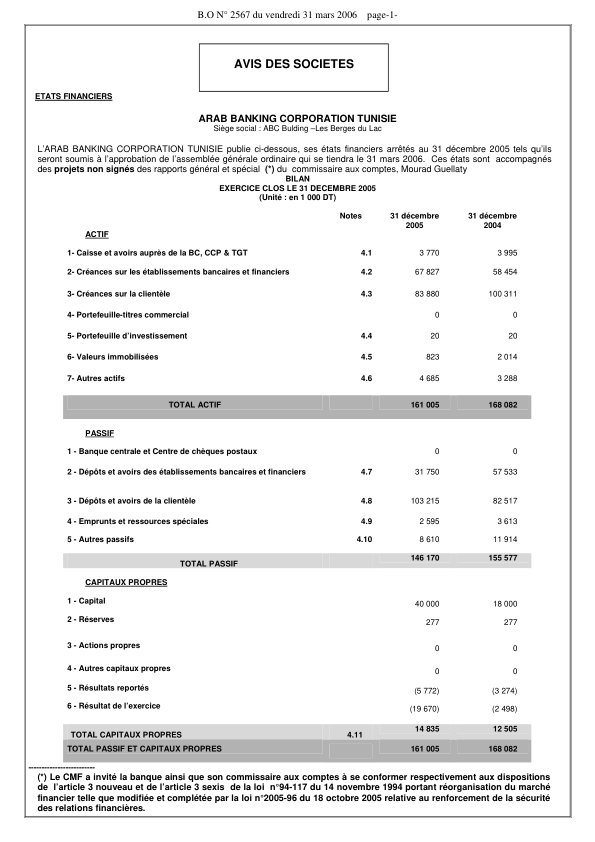

In [3]:
img = Image.open(img_path)

img

In [4]:
feature_extractor = DetrFeatureExtractor()
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

c:\Users\kortb\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\detr\feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [11]:
from huggingface_hub import hf_hub_download
from transformers import AutoImageProcessor, TableTransformerForObjectDetection
import torch
from PIL import Image


image_processor = AutoImageProcessor.from_pretrained("microsoft/table-transformer-detection")
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

inputs = image_processor(images=img, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
target_sizes = torch.tensor([img.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
    0
]



c:\Users\kortb\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kortb\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Could not find image processor class in the image processor config or the model config. Loading based on pattern matchi

In [12]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

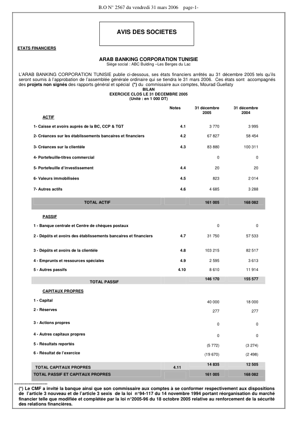

In [5]:
image = Image.open(img_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [6]:
encoding = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**encoding)
#target_sizes=target_sizes
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6)[0]
results

{'scores': tensor([0.9977, 0.9955, 0.9685, 0.9544, 0.9978, 0.9137, 0.9985, 0.8731, 0.9986,
         0.9551, 0.9198, 0.9593, 0.9576, 0.9959, 0.9998, 0.9489, 0.8638, 0.9979,
         0.9040, 0.8990, 0.9821, 0.9965, 0.9552, 0.8201, 0.9854, 0.9094, 0.8392,
         0.9218, 0.9996, 0.9903, 0.8873, 0.8340, 0.9999, 0.9937, 0.7427, 0.8485,
         0.8822, 0.8505, 0.9918, 0.9511, 0.9985, 0.7532, 0.7219, 0.8410, 0.9721,
         0.9986, 0.8971, 0.9999]),
 'labels': tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 4,
         2, 2, 2, 2, 1, 2, 4, 4, 1, 2, 3, 2, 4, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 0]),
 'boxes': tensor([[0.0593, 0.7587, 0.9258, 0.7865],
         [0.0589, 0.8806, 0.9260, 0.9043],
         [0.0587, 0.2729, 0.9272, 0.2964],
         [0.0592, 0.1277, 0.9254, 0.1524],
         [0.0595, 0.7042, 0.9253, 0.7278],
         [0.0583, 0.6322, 0.9266, 0.6554],
         [0.5335, 0.0402, 0.6393, 0.9651],
         [0.0590, 0.4205, 0.9262, 0.4523],
         [0.0593, 0.727

In [7]:
label_dict = model.config.id2label
label_dict

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [8]:
labels, boxes = results['labels'], results['boxes']

column_header = None
table_rows = []
for label, (xmin, ymin, xmax, ymax) in zip(labels.tolist(), boxes.tolist()):
    label = label_dict[label]
    if label in ['table row', 'table column header']:
        cropped_image = image.crop((xmin, ymin, xmax, ymax))
        if label == "table column header":
            column_header = cropped_image
        else:
            table_rows.append(cropped_image)

In [9]:
print(column_header)


<PIL.Image.Image image mode=RGB size=1x0 at 0x1F59E1EB880>


In [10]:
ext_df = pytesseract.image_to_data(column_header, output_type=Output.DATAFRAME, config="--psm 1")
ext_df = ext_df.dropna(subset=['text'])
ext_df['text'] = ext_df['text'].str.strip()
ext_df = ext_df[ext_df['text'].apply(len) > 1]
ext_df = ext_df.reset_index(drop=True)
extracted_columns = ext_df['text'].values.tolist()
ext_result_df = pd.DataFrame(columns=list(map(lambda x: x, range(len(extracted_columns)))))
ext_result_df.columns = extracted_columns
ext_result_df

SystemError: tile cannot extend outside image

In [ ]:
for table_row in table_rows:
    ext_df = pytesseract.image_to_data(table_row, output_type=Output.DATAFRAME, config="--psm 1")
    ext_df = ext_df.dropna(subset=['text'])
    # ext_df['text'] = ext_df['text'].str.strip()
    # ext_df = ext_df[ext_df['text'].apply(len) > 1]
    ext_df = ext_df.reset_index(drop=True)
    data = dict(zip(extracted_columns, ext_df['text'].values.tolist()))
    for col in extracted_columns:
        if col not in data:
            data[col] = np.nan
    row_df = pd.DataFrame(data=data, index=[0])
    ext_result_df = pd.concat([ext_result_df, row_df])

final_ext_df = pd.DataFrame()
for _, row in ext_result_df.iterrows():
    missing_count = row.isna().sum()
    if missing_count // len(ext_result_df.columns) == 1:
        continue
    row_df = pd.DataFrame(row).T
    final_ext_df = pd.concat([final_ext_df, row_df])

final_ext_df = final_ext_df.reset_index(drop=True)
final_ext_df.head()

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

# Download a file from the specified Hugging Face repository and location
img_path = os.path.join('.', 'ABC_EFD3112_2005_page_1.png')

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(img_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 50% of its original dimensions
resized_image = image.resize((int(width * 0.5), int(height * 0.5)))

In [ ]:
from transformers import DetrFeatureExtractor

# Create an instance of the DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()

# Use the feature extractor to encode the image
# 'image' should be the PIL image object that was obtained earlier
encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

In [ ]:
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for object detection
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")